# K-Nearest Neighbors

K-Nearest Neighbors is a simple supervised learning model that works based on the principle of similarity, assuming that similar data points are likely to have similar outcomes. This algorithm can be used both for classification or regression.

KNN is non-parametric, which means that it does not make assumptions on how the data is distributed. For this reason, this model is very useful when the relationships within the data are complex and difficult to model mathematically.

For a determined data point, the model identifies its *k* nearest neighbors in the feature space using a distance metric (in general, the Euclidean distance). For regression, it predicts the output based on the average of the target value of these neighbors; while in classification models, it assigns the predominant class of the neighbors.

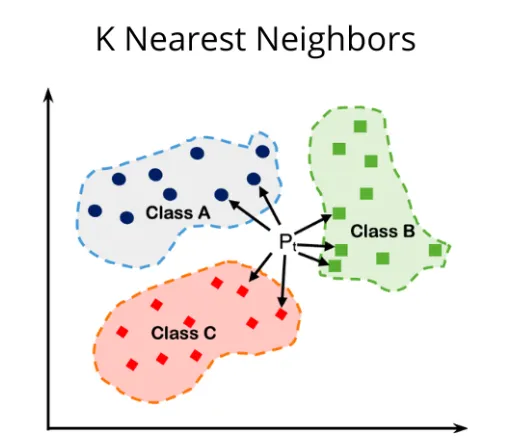

For this project, we will implement the KNN regression model to predict the critical temperature for an unknown superconductor material based on other characteristics.

The main reason for applying KNN for this problem is because superconductors with similar atomic or physical characteristics tend to have similar critical temperatures. KNN models start from the assumption that groups have similar behaviors, which is why it can help to predict the critical temperature by assuming that this value will be similar to that of other materials with similar features. Moreover, KNN does not make strong assumptions about the distribution of the data - it's flexible and useful in cases where there isn't a clear mathematical model to relate the features.

In this way, for each new material whose critical temperature we want to predict, the algorithm will pick the average of the *k* nearest neighbors in the dataset.

For this project we will:

1. Use PCA to reduce the dimensionality of the dataset
2. Try the sklearn KNN model
3. Find the optimal k for the model
4. Build a KNN model from scratch
5. Try different distance metrics





**Dataset: Superconductivity dataset from Kaggle**

In [29]:
# We import necessary libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [16]:
!pip install kaggle

In [17]:
!kaggle datasets download -d tunguz/superconductivty-data-data-set





Dataset URL: https://www.kaggle.com/datasets/tunguz/superconductivty-data-data-set
License(s): CC0-1.0
superconductivty-data-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
# Unzip the dataset
with zipfile.ZipFile("superconductivty-data-data-set.zip", "r") as zip_ref:
    zip_ref.extractall(".")


In [20]:
# We read the dataset with pandas
data = pd.read_csv("train.csv")
print(data.head())


   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

In [21]:
# We find the names of the columns
data.columns.unique()

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

**Preliminary Visual Analysis**

The idea of this initial analysis is to identify trends and to assess if the hypothesis for using the KNN model make sense before starting to develop the model.

This analysis intends to:

1.   See the distribution of the critical temperature.
2.   Define 2 main big groups (low Tc and high Tc) and see if there is a possible group behavior that can be studied with KNN.


<ipython-input-22-f8c241bab11d>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x='critical_temp', bins=30, palette='viridis', kde=True)


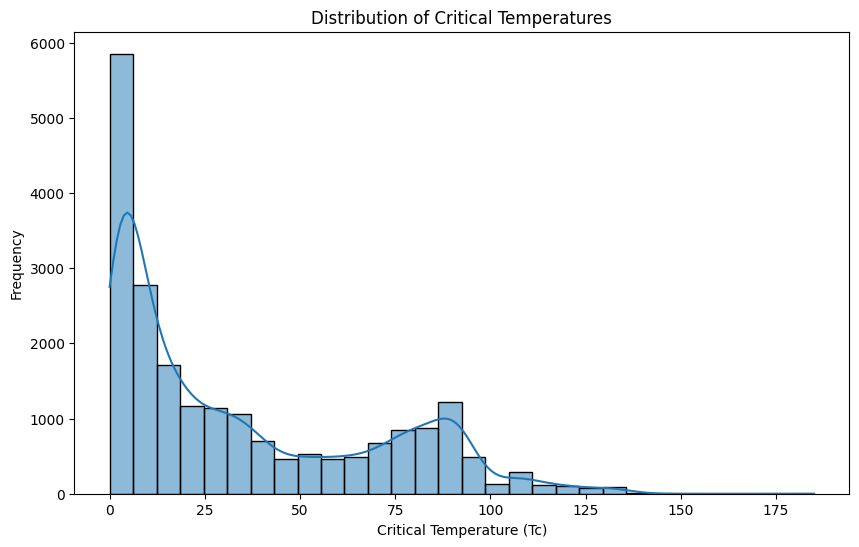

In [22]:
# Histogram for critical temperature to understand distribution
plt.figure(figsize=(10, 6))
sns.histplot(data, x='critical_temp', bins=30, palette='viridis', kde=True)
plt.xlabel('Critical Temperature (Tc)')
plt.ylabel('Frequency')
plt.title("Distribution of Critical Temperatures")
plt.show()

In [23]:
# We define a function to classify a temperature into the 2 main temperature groups
def categorize_temp_groups(temp):
    if temp < 10:
        return 'Low Tc'
    else:
        return 'High Tc'

# Apply the categorization to create a new temp_group column with the groups
data['temp_group'] = data['critical_temp'].apply(categorize_temp_groups)





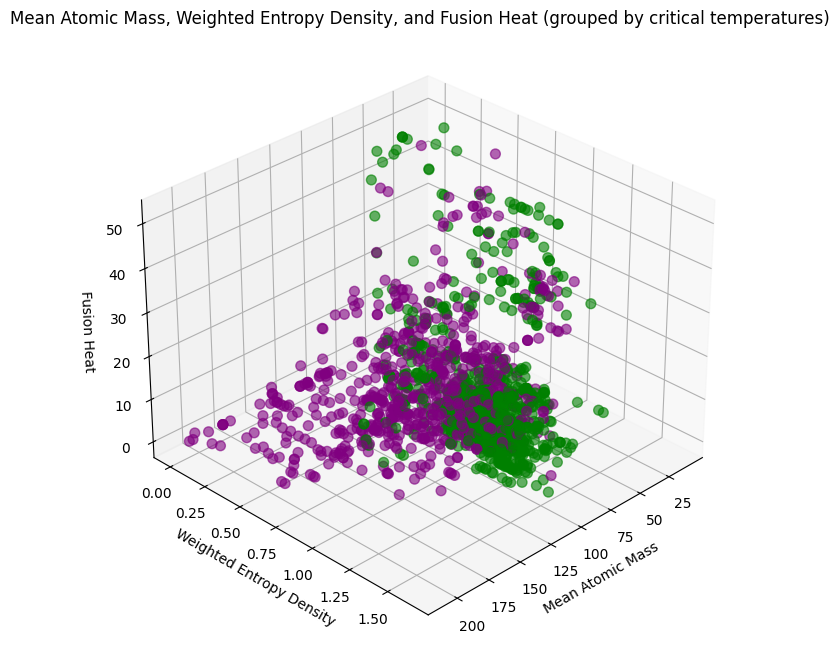

In [24]:
# Let's see if we find possible group behaviors to validate the hypothesis for KMM modeling
# We pick a random sample of 30% of the dataset for clarity
sampled_data = data.sample(frac=0.1, random_state=42)

# We make a graph with some variables to see if there is a group behavior
sampled_data['temp_group_code'] = sampled_data['temp_group'].astype('category').cat.codes
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["green", "purple"])
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=45)
ax.scatter(
    sampled_data['mean_atomic_mass'],
    sampled_data['wtd_entropy_Density'],
    sampled_data['std_FusionHeat'],
    c=sampled_data['temp_group_code'],
    cmap=custom_cmap,
    s=50,
    alpha=0.6
)

ax.set_xlabel('Mean Atomic Mass')
ax.set_ylabel('Weighted Entropy Density')
ax.set_zlabel('Fusion Heat')
ax.set_title("Mean Atomic Mass, Weighted Entropy Density, and Fusion Heat (grouped by critical temperatures)")
plt.show()







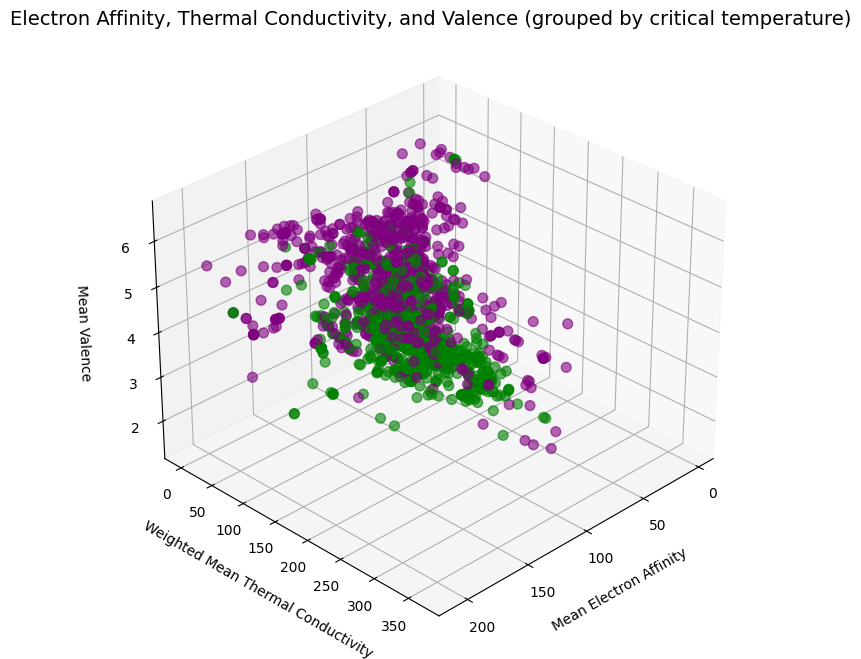

In [25]:
sampled_data = data.sample(frac=0.1, random_state=42)
sampled_data['temp_group_code'] = sampled_data['temp_group'].astype('category').cat.codes
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["green", "yellow", "purple"])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=30, azim=45)

scatter = ax.scatter(
    sampled_data['mean_ElectronAffinity'],
    sampled_data['wtd_mean_ThermalConductivity'],
    sampled_data['mean_Valence'],
    c=sampled_data['temp_group_code'],
    cmap=custom_cmap,
    s=50,
    alpha=0.6
)

ax.set_xlabel('Mean Electron Affinity', labelpad=10, fontsize=10)
ax.set_ylabel('Weighted Mean Thermal Conductivity', labelpad=10, fontsize=10)
ax.set_zlabel('Mean Valence', labelpad=10, fontsize=10)
ax.set_title("Electron Affinity, Thermal Conductivity, and Valence (grouped by critical temperature)", fontsize=14)

plt.show()



As we can see in both graphs, there is a group behavior that can possibly justify the use of KNN modeling to predict the critical temperature based on other atomic and physical characteristics.

**PCA**

Since we have 82 features for this model, we will perform an initial PCA to reduce the dimensionality of the model.

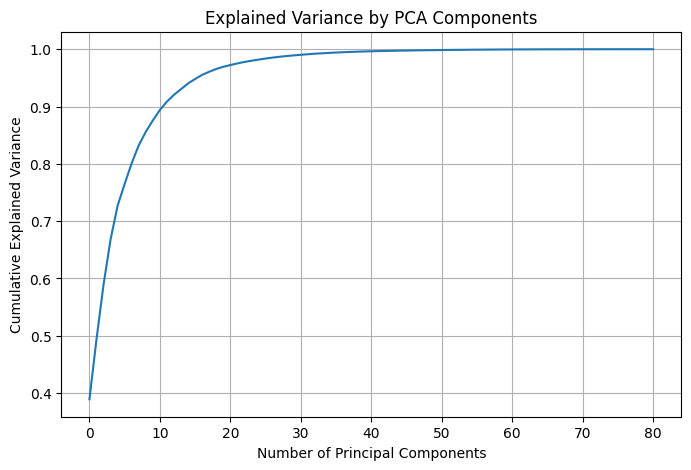

In [27]:
# We define the features
X = data.drop(columns=['critical_temp','temp_group'], errors='ignore')

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=None)  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Visualize the explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()



As we can see, most of the variance is explained by 15 features. There is an elbow in 15 that suggests that adding more features will not help to obtain a better performance. For this reason, we proceed to pick 15 features instead of 82.

In [28]:
# Reduce dimensions based on the selected number of components
n_components = 15  # Adjust this based on the elbow point or variance threshold
pca_reduced = PCA(n_components=n_components)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print("Reduced PCA data shape:", X_pca_reduced.shape)


Reduced PCA data shape: (21263, 15)


**KNN Regression model from Sklearn**

First of all, we are going to use the KNeighbors Regressor from sklearn and build a model with that library.

In [31]:
# We define the target variable, which is the critical temp
y = data['critical_temp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
n_components = 15  # Choose the number of components based on your explained variance plot
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=6)
knn_regressor.fit(X_train_pca, y_train)

# Make predictions with the test set
y_pred = knn_regressor.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")




Mean Squared Error (MSE): 135.17771877712363
Mean Absolute Error (MAE): 6.496072295553117
R-squared (R2): 0.8835373234711814


The model has an 88.3% accuracy, which is a really good result and means that the model predicts around 88.3% of the variance in the critical temperature.

Let's interpret the MSE now: this value means that the average squared difference between predicted and actual values is 135. To understand if this value is good, we need to take a look into the range and variability of the target value, which in this case is the critical temperature.

On the other hand, the MAE measures the absolute difference between the actual and predicted values. This results suggests that the predictions are off by around 6.5 units. We also need to check the range of the critical temperature and its standard deviation to assess if this value looks good.

In [32]:
# Check the range of the critical_temp variable
min_temp = data['critical_temp'].min()
max_temp = data['critical_temp'].max()
mean_temp = data['critical_temp'].mean()
std_temp = data['critical_temp'].std()

print(f"Critical Temp Range: {min_temp} to {max_temp}")
print(f"Mean Critical Temp: {mean_temp}")
print(f"Standard Deviation of Critical Temp: {std_temp}")


Critical Temp Range: 0.00021 to 185.0
Mean Critical Temp: 34.42121913535249
Standard Deviation of Critical Temp: 34.2543624487443


Given the standard deviation of the target variable, the MSE seems reasonable as it's sqaure root is around 1/3 of the normal deviation. So does the MAE, which is about 18% of the standard deviation.

**Find the optimal *k* value**

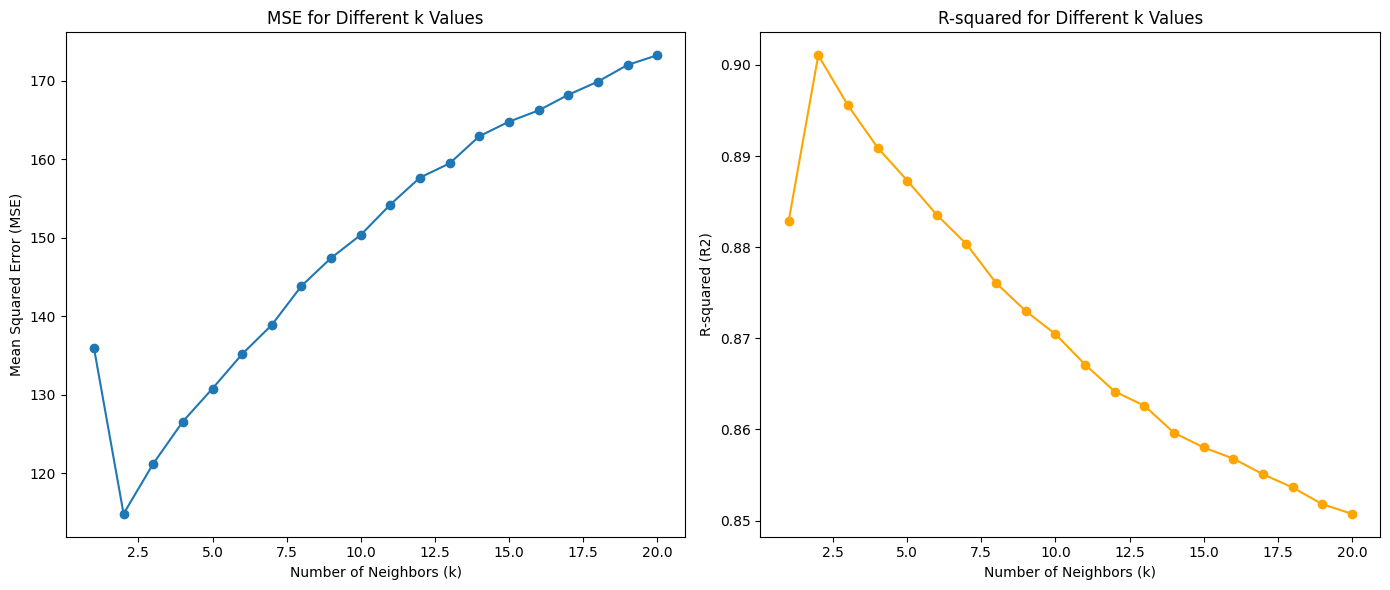

In [33]:
# Range of k values
k_values = range(1, 21)  # Testing k from 1 to 20
mse_scores = []
r2_scores = []

# Loop over k values and evaluate the model
for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_pca, y_train)  # Fit on PCA-transformed training data
    y_pred = knn_regressor.predict(X_test_pca)  # Predict on PCA-transformed test data
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    mse_scores.append(mse)
    r2_scores.append(r2)

# Plotting the MSE and R2 scores for different k values
plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(k_values, mse_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for Different k Values")

# Plot R-squared
plt.subplot(1, 2, 2)
plt.plot(k_values, r2_scores, marker='o', color='orange')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("R-squared (R2)")
plt.title("R-squared for Different k Values")

plt.tight_layout()
plt.show()

We can see that the lowest MSE and highest R2 are around k=2. However, using only 2 neighbors can cause overfitting since the model is focusing on a very limited number of neighbors for each prediction. This can also generate a lot of sensitivity to outliers. For this reason, a k=4 seems reasonable for the model.

**KNN model built from scratch**

Now let's try to build our own KNN model from scratch and compare it to the one we obtained using the sklearn library. For this model, we will define a function to calculate the Euclidean distance as:

$$
\text{distance}(p, q) = \sqrt{\sum (p_i - q_i)^2}
$$

This formula calculates the Euclidean distance between two points \( p \) and \( q \) in an \( n \)-dimensional space.




In [34]:
# We define a function to calculate the Euclidean distance
def distance(p, q):
    return np.sqrt((p - q) @ (p - q))

# We define a function to calculate k neighbors
def k_nearest_neighbors(point, training_features, training_labels, k):
    neighbors = []
    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        neighbors.append((label, d))
    neighbors.sort(key=lambda x: x[1])  # Sort by distance
    return neighbors[:k]

# We define the predicting KNN function
def KNN_Predict(point, training_features, training_labels, k):
    neighbors = k_nearest_neighbors(point, training_features, training_labels, k)
    # Take the mean of the labels for regression
    return np.mean([label for label, _ in neighbors])

# We define the MSE calculation
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# We dfine the R-squared calculation
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)




In [35]:
# Now that we the function, we can execute the model
k = 4
predictions = [KNN_Predict(point, X_train_pca, y_train.values, k) for point in X_test_pca]
mse = mean_squared_error(y_test.values, predictions)
r2 = r_squared(y_test.values, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 124.87
R-squared (R2): 0.8924


We can see that our built-from-scratch model with k=4 achieved a higher accuracy of 89.2% and lower MSE of 124.9

**Try with some other distance metrics**

Now let's try to build other models with other distance metrics.

Manhattan distance:

$$
\text{distance}(p, q) = \sum_{i=1}^n |p_i - q_i|
$$

Minkowski distance:

$$
\text{distance}(p, q) = \left( \sum_{i=1}^n |p_i - q_i|^p \right)^{\frac{1}{p}}
$$


In [36]:
# Manhattan distance function
def manhattan_distance(p, q):
    return np.sum(np.abs(p - q))


In [37]:
# Minkowski distance function with an order parameter
def minkowski_distance(p, q, order=3):  # Default is 3, but you can adjust as needed
    return np.sum(np.abs(p - q) ** order) ** (1 / order)


In [38]:
# Now we will modify the  k_nearest_neighbors function to accept a distance function
def k_nearest_neighbors(point, training_features, training_labels, k, distance_func):
    neighbors = []
    for p, label in zip(training_features, training_labels):
        d = distance_func(point, p)
        neighbors.append((label, d))
    neighbors.sort(key=lambda x: x[1])  # Sort by distance
    return neighbors[:k]

# Modify KNN_Predict to accept a custom distance function
def KNN_Predict(point, training_features, training_labels, k, distance_func):
    neighbors = k_nearest_neighbors(point, training_features, training_labels, k, distance_func)
    # Take the mean of the labels for regression
    return np.mean([label for label, _ in neighbors])


In [39]:
# Predictions with Manhattan distance
y_pred_manhattan = [
    KNN_Predict(point, X_train_pca, y_train.values, k=5, distance_func=manhattan_distance)
    for point in X_test_pca
]

# Predictions with Minkowski distance (order 3)
y_pred_minkowski = [
    KNN_Predict(point, X_train_pca, y_train.values, k=5, distance_func=lambda p, q: minkowski_distance(p, q, order=3))
    for point in X_test_pca
]

# Calculate MSE and R2 for Manhattan distance
mse_manhattan = mean_squared_error(y_test.values, y_pred_manhattan)
r2_manhattan = r_squared(y_test.values, y_pred_manhattan)

# Calculate MSE and R2 for Minkowski distance
mse_minkowski = mean_squared_error(y_test.values, y_pred_minkowski)
r2_minkowski = r_squared(y_test.values, y_pred_minkowski)

# Print results
print("Manhattan Distance:")
print(f"Mean Squared Error (MSE): {mse_manhattan:.2f}")
print(f"R-squared (R2): {r2_manhattan:.4f}")

print("\nMinkowski Distance (order 3):")
print(f"Mean Squared Error (MSE): {mse_minkowski:.2f}")
print(f"R-squared (R2): {r2_minkowski:.4f}")


Manhattan Distance:
Mean Squared Error (MSE): 126.49
R-squared (R2): 0.8910

Minkowski Distance (order 3):
Mean Squared Error (MSE): 129.60
R-squared (R2): 0.8883


We can see that using different distance metrics does not imply significantly different results. However, the Euclidean distance seems to be the best fit for this case.